<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/initial_dataprocessing_stockvalue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

## Kernel setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb

In [5]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## General setup

In [30]:
%%capture
!cd npmf && git pull

import os
from collections import defaultdict
from collections import Counter
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.eikon import column_mapping
from npmf.utils.wandb import put_dataset, get_df_artifact
from npmf.utils.data import test_start_pd

In [7]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
np.random.seed(420)

# Let's get the data and and check it 😂✨KAWAIII ^^✨



In [10]:
data = get_df_artifact("oil-company-data:v1", project="master-test").set_index("Instrument")

wandb: Currently logged in as: krankile (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact oil-company-data:v1, 461.61MB. 1 files... Done. 0:0:0


In [11]:
data = data[~(data.Date == "")].astype({"Date": np.datetime64})
data

,Date,Company Market Cap,Price Close,Currency
Instrument,,,,
GGX.AX,2005-05-13,4510832.105479,0.116764,USD
GGX.AX,2005-05-16,4486502.643904,0.116764,USD
GGX.AX,2005-05-17,4483522.209137,0.116057,USD
GGX.AX,2005-05-18,4519172.59536,0.116057,USD
GGX.AX,2005-05-19,3827143.993207,0.099066,USD
...,...,...,...,...
AEC.V,2022-04-14,43250854.906096,0.10716,USD
AEC.V,2022-04-18,43082857.134364,0.107015,USD
AEC.V,2022-04-19,43079442.196417,0.107015,USD


## Number of unique companies

In [12]:
tickers = data[~data["Company Market Cap"].isna()].index.unique()

print(f"{tickers.shape[0]} unique companies in the set")

1697 unique companies in the set


## Number of datapoints for the market cap

In [13]:
marketcaps = data.shape[0]
print(f"There is a total of {marketcaps} datapoints in the dataset")

marketcaps = data[~data["Company Market Cap"].isna()].shape[0]
print(f"There is a total of {marketcaps} datapoints in the dataset that are not NAs")

There is a total of 6230549 datapoints in the dataset
There is a total of 6117652 datapoints in the dataset that are not NAs


# Start process of sorting out data

First, cut of leading and trailing NAs for all companies.

## Remove leading and trailing NAs

In [14]:
stripped = []
points_stripped = 0

for ticker in tqdm(tickers):
    d = data.loc[ticker, ]
    start = 0
    end = d.shape[0]

    # Start at the beginning and find first real value
    for i, val in enumerate(d["Company Market Cap"]):
        if not pd.isna(val):
            start = i
            break
    points_stripped += i

    for i, val in enumerate(d["Company Market Cap"][::-1]):
        if not pd.isna(val):
            end -= i
            break
    points_stripped += i

    stripped.append(d.iloc[start:end, ])

stripped = pd.concat(stripped, axis=0)

print(f"Total of {stripped.shape[0]} datapoints after stripping")

100%|██████████| 1697/1697 [03:37<00:00,  7.81it/s]


Total of 6169474 datapoints after stripping


Then, consider different strategies for sorting out companies. For example

1.   Make sure companies have less than $p$% NAs for all quarters
2.   Take out companies where each string of missing values are longer than $n$

## Remove companies with long streaks of NAs

In [15]:
def na_streak_maxlen(ser):

    longest = 0
    curr = 0

    for val in ser:
        if not pd.isna(val):
            curr = 0
            continue
        
        curr += 1

        if curr > longest:
            longest = curr

    return longest

In [16]:
s = pd.Series([1, 2, 3, pd.NA, pd.NA, pd.NA, 1, pd.NA, pd.NA, 5, 6, 7])
na_streak_maxlen(s)

3

In [17]:
longest_gap = dict()

for ticker in tqdm(tickers):
    longest_gap[ticker] = na_streak_maxlen(stripped.loc[ticker, "Company Market Cap"])

100%|██████████| 1697/1697 [03:37<00:00,  7.81it/s]


In [18]:
counts = stripped.reset_index().groupby("Instrument").count()
points = dict(zip(counts.index, counts["Company Market Cap"]))

In [19]:
ks = sorted(set(longest_gap.values()))

runtot_comp = 0
runtot_data = 0
left = set(tickers)

companies = []
datapoints = []

for k in tqdm(ks):
    for ticker in left.copy():
        if longest_gap[ticker] <= k:
            runtot_comp += 1
            runtot_data += points[ticker]
            left.remove(ticker)

    companies.append(runtot_comp)
    datapoints.append(runtot_data)

100%|██████████| 102/102 [00:00<00:00, 18054.48it/s]


In [20]:
np.array(datapoints) / sum(points.values())

array([0.93656946, 0.93749301, 0.9383538 , 0.93927703, 0.93954053,
       0.94042077, 0.9413422 , 0.94193328, 0.94264384, 0.94340361,
       0.94382355, 0.94470509, 0.94504264, 0.94561083, 0.94619815,
       0.94680639, 0.94729089, 0.94797367, 0.94851195, 0.94911005,
       0.94945299, 0.95030659, 0.95057205, 0.95112112, 0.9514567 ,
       0.95209486, 0.95299504, 0.95389506, 0.95561189, 0.95626868,
       0.95691321, 0.95824934, 0.95875051, 0.95961294, 0.95981579,
       0.96045705, 0.96062362, 0.96143994, 0.96233228, 0.96309761,
       0.96395186, 0.96481117, 0.96537152, 0.96623067, 0.96667251,
       0.96720556, 0.96814366, 0.96884262, 0.96968249, 0.97053428,
       0.97115985, 0.9728914 , 0.97365166, 0.97453386, 0.97504206,
       0.97568217, 0.97647235, 0.97686547, 0.97724944, 0.9776169 ,
       0.97848325, 0.9789192 , 0.9794735 , 0.97971885, 0.98054907,
       0.98106332, 0.98156106, 0.98196628, 0.98258155, 0.98336911,
       0.98350871, 0.98393272, 0.98474317, 0.98555214, 0.98614

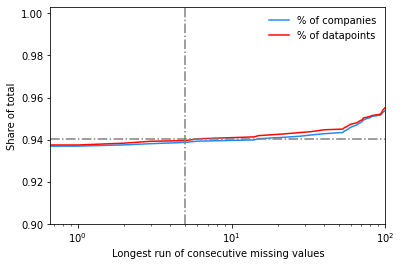

In [21]:
total_comp = stripped.index.unique().shape[0]
total_points = sum(points.values())

c = np.array(companies) / total_comp
d = np.array(datapoints) / total_points

plt.plot(ks, c, label="% of companies")
plt.plot(ks, d, label="% of datapoints")

plt.xscale("log")
plt.ylim(bottom=0.9)
plt.xlim(right=100)
plt.xlabel("Longest run of consecutive missing values")
plt.ylabel("Share of total")
plt.axhline(y=0.94042077, color="gray", linestyle="-.")
plt.axvline(x=5, color="gray", linestyle="-.")
plt.legend(frameon=False);

### Find all tickers where the gaps are shorther than or equal to 5 points

In [22]:
longest_gap.items()

dict_items([('GGX.AX', 0), ('AUSG.SI', 0), ('TNEN.PK', 0), ('CARM.KL', 0), ('6477.TW', 0), ('000968.SZ', 0), ('NEL.OL', 0), ('MTR.N', 0), ('MET.V', 0), ('INDY.JK', 0), ('HFC.HNO', 59), ('SZR.WA', 0), ('VMY.AX', 0), ('PIPE.TO', 0), ('OIL.CD', 0), ('WHD.N', 0), ('137950.KQ', 0), ('YITD.PK', 0), ('EFR.TO', 0), ('PPIH.OQ', 0), ('XL.V', 0), ('MUR.N', 0), ('NBR.N', 0), ('5015.T', 0), ('FPI.PS', 155), ('CEI.A', 0), ('NESTE.HE', 0), ('ROCOTN.BX', 0), ('FOSP.BX', 440), ('AGE.BK', 0), ('OANDO.LG', 0), ('PFC.L', 0), ('VLLP.PA', 0), ('BISI.L', 0), ('601798.SS', 0), ('CLC.WA', 0), ('IPEKE.IS', 0), ('PHEG.L', 0), ('APLP.TA', 0), ('000096.SZ', 0), ('SHE.AX', 428), ('TRXO.PK', 0), ('RAKP.OL', 0), ('603637.SS', 0), ('MG.N', 0), ('CHARC.L', 0), ('JGH.AX', 510), ('NC.N', 0), ('NR.N', 0), ('RVTI.PK', 0), ('PMG.HM', 0), ('BOSS.JK', 0), ('QGTS.QA', 0), ('PNE.TO', 0), ('BKEP.OQ', 0), ('KEY.AX', 0), ('BMN.AX', 0), ('MEG.TO', 0), ('TVK.TO', 0), ('JSKY.JK', 0), ('AAKA.NS', 0), ('ESI.TO', 0), ('OII.N', 0), ('OKE

In [23]:
include_tickers = sorted(list(map(lambda x: x[0], filter(lambda x: x[1] <= 5, longest_gap.items()))), key=lambda x: x[1], reverse=True)

In [24]:
cleandf = stripped.loc[include_tickers, ].fillna(method="ffill")
cleandf

,Date,Company Market Cap,Price Close,Currency
Instrument,,,,
SZR.WA,2010-02-19,4316546.76259,0.061665,USD
SZR.WA,2010-02-22,6255155.347814,0.089359,USD
SZR.WA,2010-02-23,7567823.237272,0.108112,USD
SZR.WA,2010-02-24,7851000.917649,0.112157,USD
SZR.WA,2010-02-25,8833862.00075,0.126198,USD
...,...,...,...,...
300772.SZ,2022-04-15,1421837745.71855,2.621458,USD
300772.SZ,2022-04-18,1454200172.46267,2.681125,USD
300772.SZ,2022-04-19,1438043708.32942,2.651337,USD


In [25]:
print(f"After clean, {cleandf.index.unique().shape[0]} companies remain")
print(f"After clean, {cleandf.shape[0]} datapoints remain")

After clean, 1593 companies remain
After clean, 5747793 datapoints remain


## Remove companies that are traded over the counter

Also called Pink Slips (PK)

In [27]:
cleandf = cleandf[~cleandf.index.str.endswith(".PK")]

print(f"After drop PK companies, {cleandf.index.unique().shape[0]} companies remain")
print(f"After drop PK companies, {cleandf.shape[0]} datapoints remain")

After drop PK companies, 1454 companies remain
After drop PK companies, 5231629 datapoints remain


## Remove companies with too little training or test data after split

### Rename columns to be easier to work with

In [32]:
data = cleandf.reset_index().rename(columns=column_mapping)
data.head()

,ticker,date,market_cap,close_price,currency
0,SZR.WA,2010-02-19,4316546.76259,0.061665,USD
1,SZR.WA,2010-02-22,6255155.347814,0.089359,USD
2,SZR.WA,2010-02-23,7567823.237272,0.108112,USD
3,SZR.WA,2010-02-24,7851000.917649,0.112157,USD
4,SZR.WA,2010-02-25,8833862.00075,0.126198,USD


### Create a split of data for training and testing

All data from, and including, January 1st, 2019 will be reserved for the test set. All other data can be used for training.

In [33]:
train_test_split = data.date < test_start_pd

train = data[train_test_split]
test = data[~train_test_split]

train.shape, test.shape

((4083273, 5), (1148356, 5))

After the split, the training set contains ~4.1M stock prices, while the test set has ~1.1M. There are ~5 trading days in a week, ~20 in a month, ~60 in a quarter, and ~250 in a year. If forecasting a month into the future, it is reasonable to require at least a quarter's worth of training data, minimum. Therefore, we require included companies to have at least a quarter plus a month worth of days (i.e., 80) in the training set to be included.

In [38]:
trn_count = train.groupby("ticker").count()
tst_count = test.groupby("ticker").count()

exclude_tickers = pd.concat(
    [
     trn_count[trn_count.market_cap < 80],
     tst_count[tst_count.market_cap < 20],
    ]
).index.unique()

exclude_tickers.shape[0]

18

When imposing this requirement, we lose 18 tickers.

In [39]:
train = train[~train.ticker.isin(exclude_tickers)]
test = test[~test.ticker.isin(exclude_tickers)]

train.shape, test.shape

((4080794, 5), (1136757, 5))

### Combine into one frame

In [42]:
data = pd.concat([train, test], axis=0).sort_values(by=["ticker", "date"]).reset_index().drop(columns=["index"])

data.ticker.unique().shape[0], data.shape[0]

(1436, 5217551)

# Save the data to WandB 👫

In [43]:
filename = "stock-data-clean.feather"

put_dataset(data, filename, project="master-test", description="Remove PK companies also and do sufficiency clean")